In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

import scipy as sp
import seaborn as sns


import sys
sys.path.append('..')
import src.data.util as du
import src.text.tokenizer as tk

# Data setup

In [2]:
data_file = '../results/complexity_utf-16_2020_10_10_bibles_lcm.csv'
bible_file = '../dataset/' + re.match('.*(bibles_.*)', data_file).group(1)

df = pd.read_csv(data_file, index_col=False)
df = df[df.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
df.loc[df.metric == 'del-chars', 'value'] = - df.loc[df.metric == 'del-chars', 'value']
bibles = pd.read_csv(bible_file, index_col=False)
bibles = bibles[bibles.language != 'NAMBIKUÁRA']

In [3]:
df.head()

,language,wals,metric,algorithm,value,run_id
0,ANCIENT_GREEK,[grc],del-verses,gzip,0.904723,0
1,ANCIENT_GREEK,[grc],del-verses,gzip,0.909796,1
2,ANCIENT_GREEK,[grc],del-verses,gzip,0.902007,2
3,ANCIENT_GREEK,[grc],del-verses,gzip,0.903372,3
4,ANCIENT_GREEK,[grc],del-verses,gzip,0.908029,4


# Helper functions

In [4]:
def get_indexes(df):
    langs = df.drop_duplicates("language").sort_values("value").language
    ret = {
        col : i
    for i, col in enumerate(langs)
    }
    return ret


def index_difference(id1, id2):
    ids = id1.keys() & id2.keys()
    ret = {
        i : (id1[i] - id2[i])
        for i in ids
    }
    return ret


def compute_numtypes_numtokens(df):
    langs = du.by_field(df, 'language')
    united = {
        lang : du.df_to_str(val)
        for lang, val in langs.items()
    }

    d = dict(language=[], tokens=[], types=[])
    for lang, text in united.items():
        d['language'].append(lang)
        tokens = tk.tokens(text)
        d['tokens'].append(len(tokens))
        d['types'].append(len(tk.types(tokens)))
    return d
       

def fetch_algorithm(df, metric, algo):
    df2 = df[(df.algorithm == algo) & (df.metric == metric)]
    by = ["language"]
    m = df2.groupby(by=by).value.transform("mean")
    s = df2.groupby(by=by).value.transform("std")
    df2['mean'] = m
    df2['std'] = s
    return df2.drop_duplicates('language').sort_values('language').reset_index().drop(columns='index')


def fetch_all_metric_algorithms(df):
    by = ["language", "metric", "algorithm"]
    m = df.groupby(by=by).value.transform("mean")
    s = df.groupby(by=by).value.transform("std")
    df2 = df.copy()
    df2["mean"] = m
    df2["var"] = s**2
    return df2.drop_duplicates(by).sort_values('language').reset_index().drop(columns=['index', 'run_id'])

# H1 Overall complexity of a text

The overall complexity of a text in its
original language is lower than in the other
languages, as a result of the introduction
of cultural clarification in the translation process.
The language complexity of a translated text should be greater than their counterpart in the source language.

In [5]:
def h1(df, algo):
    df = df.copy()
    df = df[df.language != 'SATERÉ-MAWÉ']
    dn = df.metric == 'do-nothing'
    nn = df.algorithm == 'none'
    ag = df.algorithm == algo
    raw = df[dn & nn].drop_duplicates('language').reset_index().drop(columns='index')
    rco = df[dn & ag].drop_duplicates('language').reset_index().drop(columns='index')

    language = list(raw.sort_values('language').language)
    x = raw.sort_values('language').value.to_numpy()
    y = rco.sort_values('language').value.to_numpy()
    lr = sp.stats.linregress(x, y)
    ỹ = (lr.slope*x + lr.intercept)
    overall_complexities =  y - ỹ

    return pd.DataFrame(dict(language=language, oc=overall_complexities, raw=x, comp=y)), x, ỹ

    return overall_complexities

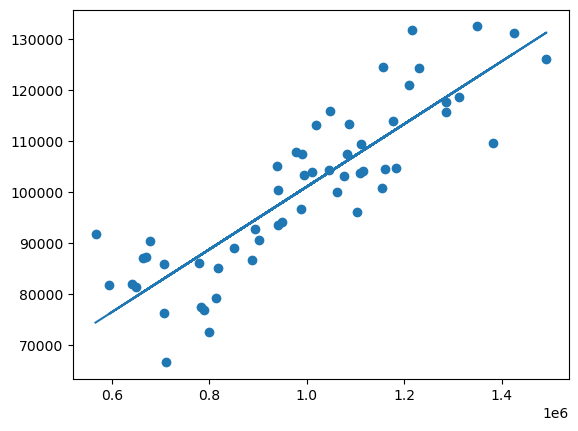

In [6]:
docb, xb, yb = h1(df, 'bz2')
plt.plot(xb, yb)
plt.scatter(docb['raw'], docb['comp'])

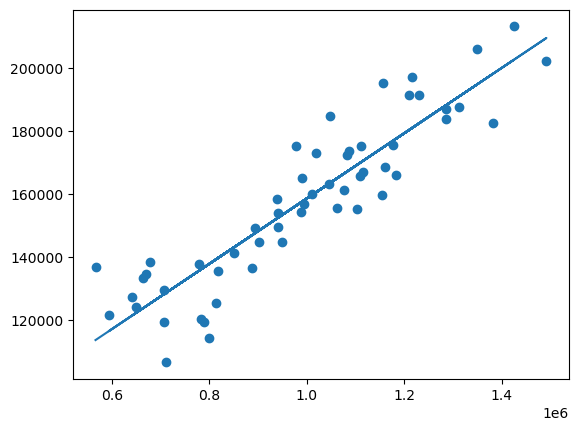

In [7]:
docg, xg, yg = h1(df, 'gzip')
plt.plot(xg, yg)
plt.scatter(docg['raw'], docg['comp'])

In [8]:
def compute_num_chars(df):
    from collections import Counter
    d = dict(language=[], chars=[])
    for lang in set(df.language):
        c = Counter('\n'.join(df[df.language == lang].text))
        d['language'].append(lang)
        d['chars'].append(len(c))
    dd = pd.DataFrame(d)
    return dd

In [9]:
dd = compute_num_chars(bibles[bibles.language != 'SATERÉ-MAWÉ']).sort_values('language').reset_index().drop(columns='index')

In [10]:
sp.stats.pearsonr(dd.chars.to_numpy(), docg.oc.to_numpy())

PearsonRResult(statistic=0.4491338586575021, pvalue=0.0005826011924897157)

In [11]:
sp.stats.pearsonr(dd.chars.to_numpy(), docb.oc.to_numpy())

PearsonRResult(statistic=0.4487751256937995, pvalue=0.00058926893685396)

# H2 Content invariance
For any complexity measure, Bible complexity should be the same (independenlty of translation).
In this case, we should observe a smaller variance in size in bytes of the compressed texts in comparison with
the uncompressed texts.

In [12]:
def deviation_across_languages(df):
    df2 = df.loc[:, :]
    by = ["metric", "algorithm"]
    m = df.groupby(by=by).value.transform("mean")
    s = df.groupby(by=by).value.transform("std")
    df2['mean'] = m
    df2['std'] = s
    return df2.sort_values('language').reset_index().drop(columns='index')

In [13]:
daldf = deviation_across_languages(df)

In [14]:
np.log10(daldf[(daldf.metric == 'do-nothing') & (daldf.algorithm == 'none')]['std'].unique().item()**2)

10.73122995475016

In [15]:
np.log10(daldf[(daldf.metric == 'do-nothing') & (daldf.algorithm == 'gzip')]['std'].unique().item()**2)

8.868403848577477

In [16]:
np.log10(docg.oc.std()**2)

8.076164227591573

In [17]:
np.log10(daldf[(daldf.metric == 'do-nothing') & (daldf.algorithm == 'bz2')]['std'].unique().item()**2)

8.454212982200906

In [18]:
np.log10(docb.oc.std()**2)

7.811021339066707

<Axes: xlabel='oc', ylabel='Count'>

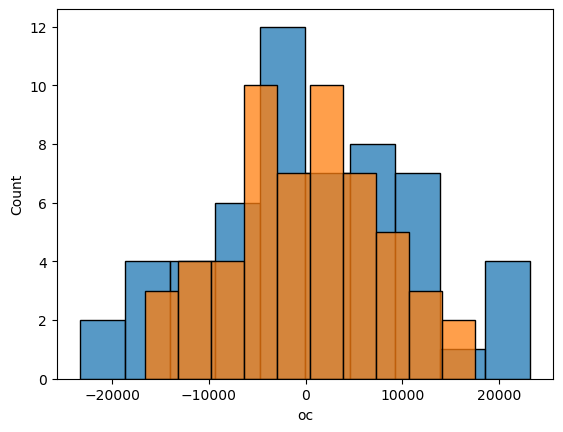

In [19]:
#sns.histplot(df[(df.metric == 'do-nothing') & (df.algorithm == 'none')], x='value', bins=10)
sns.histplot(docg, x='oc', bins=10, label='gzip')
sns.histplot(docb, x='oc', bins=10)
#TODO: Multihistograma

# H3 Morphology and Syntatic trade-off
Languages that have a higher morphological complexity show a smaller syntatic complexity and vice-versa.

In [20]:
del_chars_gzip = fetch_algorithm(df, 'del-chars', 'gzip') # Morphological
del_chars_bz2  = fetch_algorithm(df, 'del-chars', 'bz2')

del_words_gzip = fetch_algorithm(df, 'del-words', 'gzip') # Syntatic
del_words_bz2 = fetch_algorithm(df, 'del-words', 'bz2')

## Caution
To measure this we can not rely on direct correlation. This is because both complexity measures
are computed in the same way, which gives a positive correlation. So the proper way of doing the measure
is computing the correlation between the residuals of two linear regressions one from morphological to syntatic, and other from syntatic to morphological.

In [21]:
del_chars_gzip['mean'].corr(del_words_gzip['mean'], method='pearson')

-0.454189876665531

In [22]:
del_chars_bz2['mean'].corr(del_words_bz2['mean'], method='pearson')

-0.4712990142956483

In [23]:
indo_european_languages = ("ANCIENT_GREEK", "ENGLISH", "FRENCH", "GERMAN", "PORTUGUESE", "SPANISH")

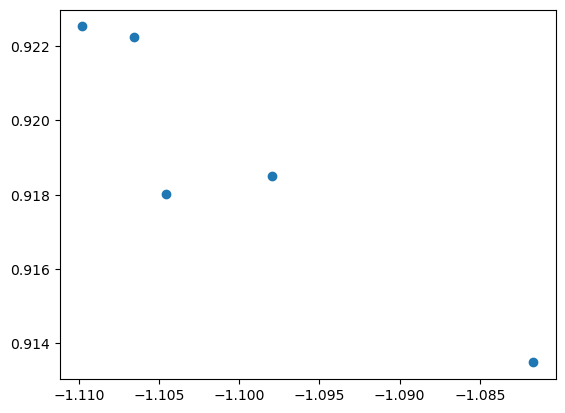

In [24]:
plt.scatter(del_chars_gzip[del_chars_gzip.language.isin(indo_european_languages)]['mean'],
            del_words_gzip[del_words_gzip.language.isin(indo_european_languages)]['mean'])

In [25]:
del_chars_gzip[del_chars_gzip.language.isin(indo_european_languages)]['mean'].corr(del_words_gzip[del_words_gzip.language.isin(indo_european_languages)]['mean'], method='pearson')

-0.9293806317393765

In [26]:
del_chars_gzip[del_chars_gzip.language.isin(indo_european_languages)]['mean'].corr(del_words_gzip[del_words_gzip.language.isin(indo_european_languages)]['mean'], method='spearman')

-0.8999999999999998

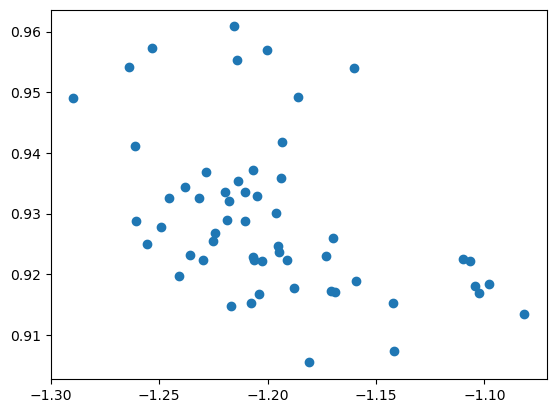

In [27]:
plt.scatter(del_chars_gzip['mean'],
            del_words_gzip['mean'])

## Computing the residuals

In [28]:
def h3(dfi, alg):
    df = dfi.copy()
    ag = df.algorithm == alg
    dw = df.metric == 'del-words'
    dc = df.metric == 'del-chars'
    
    x = df[dw & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()
    y = df[dc & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()

    df.loc[dw & ag, 'del-words'] = x
    df.loc[dw & ag, 'del-chars'] = y
    df = df.dropna().drop_duplicates('language').reset_index().drop(columns=['metric', 'index', 'run_id'])
    #df.dropna(inplace=True)
    #df.drop(columns='metric')
    #print(x.shape, y.shape)
    #df.loc[dw, 'del-chars'] = y
    #df = df.drop_duplicates(['language', 'algorithm'])
    #df.assign('del-words'] = 0.0
    #df.loc[dw, 'del-words'] = x
    #df.loc[:, 'del-chars'] = 0.0
    #df.loc[dc, 'del-chars'] = y

    #return df42
    #df42 = df42.drop_duplicates(['metric', 'language'])
    return df
    df42 = df42[df42.metric.isin(['del-words', 'del-chars'])]
    df42_words = df42.loc[df42.metric == 'del-words'].reset_index()
    df42_chars = df42.loc[df42.metric == 'del-chars'].reset_index()
    df42_chars['del-words'] = df42_words['del-words']
    df42 = df42_chars
    return df42_chars

In [29]:
r = h3(df, 'gzip')

In [30]:
r

,language,wals,algorithm,value,del-words,del-chars
0,ANCIENT_GREEK,[grc],gzip,0.913248,0.913489,-1.081678
1,APALAÍ,apl,gzip,0.921317,0.922152,-1.202435
2,APINAYÉ,api,gzip,0.955529,0.955251,-1.214221
3,APURINÃ,apu,gzip,0.915092,0.914863,-1.217044
4,ASHENINKA,cax,gzip,0.904605,0.905481,-1.180946
5,BAKAIRI,bki,gzip,0.916331,0.917233,-1.170913
6,BORÔRO,brr,gzip,0.939910,0.941149,-1.261372
7,CANELA,cnl,gzip,0.948808,0.949248,-1.186128
8,CULINA,cul,gzip,0.925748,0.924976,-1.255837
9,DESANO,des,gzip,0.922645,0.923764,-1.194892


In [31]:
def ploth3(df, algo, wals=None):
    wals = wals or set(df.wals)
    
    df = h3(df[df.wals.isin(wals)], algo)

    x = df['del-chars'].to_numpy()
    y = df['del-words'].to_numpy()
    l = df['wals'].to_numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y)
    plt.xlabel('Morphological Complexity')
    plt.ylabel('Syntatic Complexity')
    plt.title(f"Trade-off hypothesis with {algo.capitalize()}")
    plt.legend()
    for i, lang in enumerate(l):
        plt.annotate(lang, (x[i], y[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


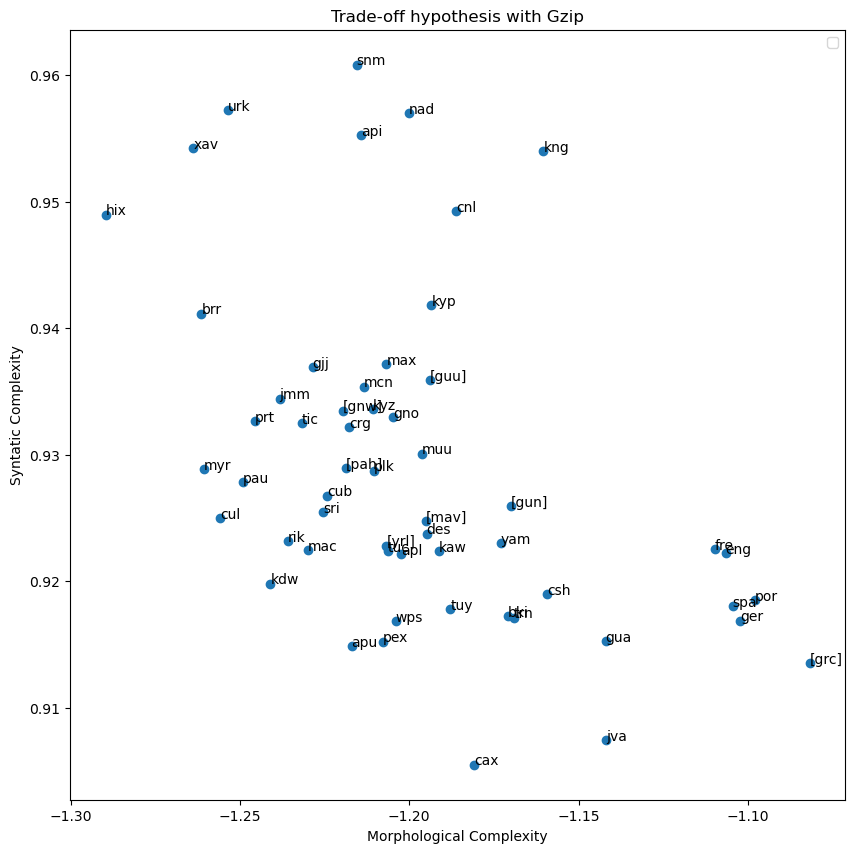

In [32]:
ploth3(df, 'gzip', None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


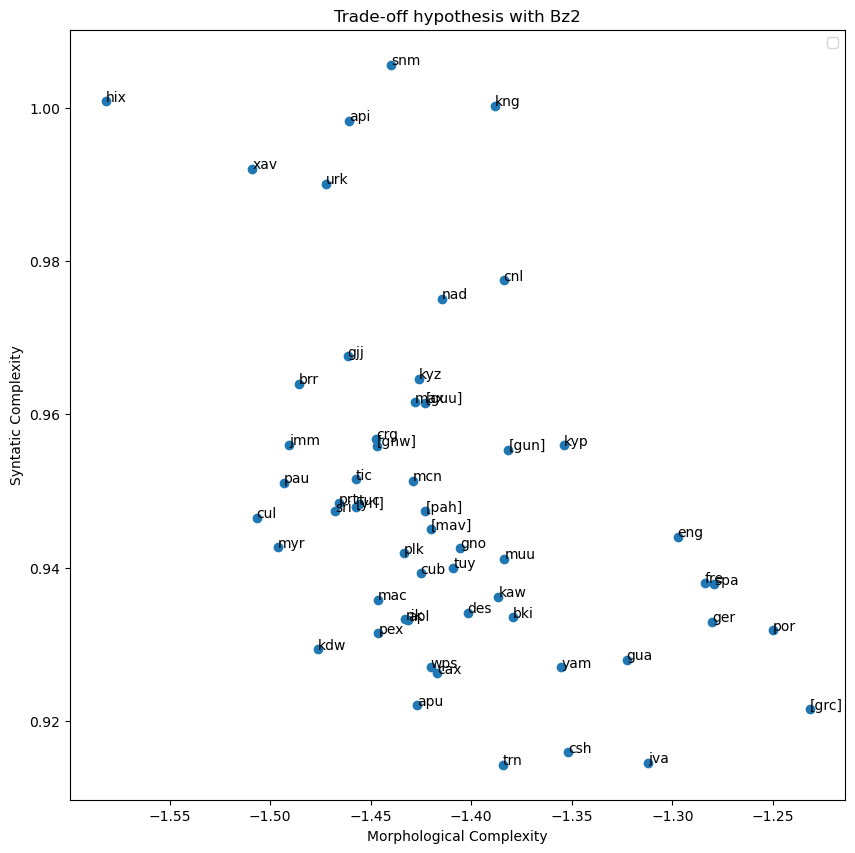

In [33]:
ploth3(df, 'bz2', None)

## Removing outliers

In [34]:
languages = set(df.wals)
outliers1 = set(("nad", "kng"))
outliers2 = set(("eng", 'fre', 'por', 'spa', 'ger', '[grc]'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


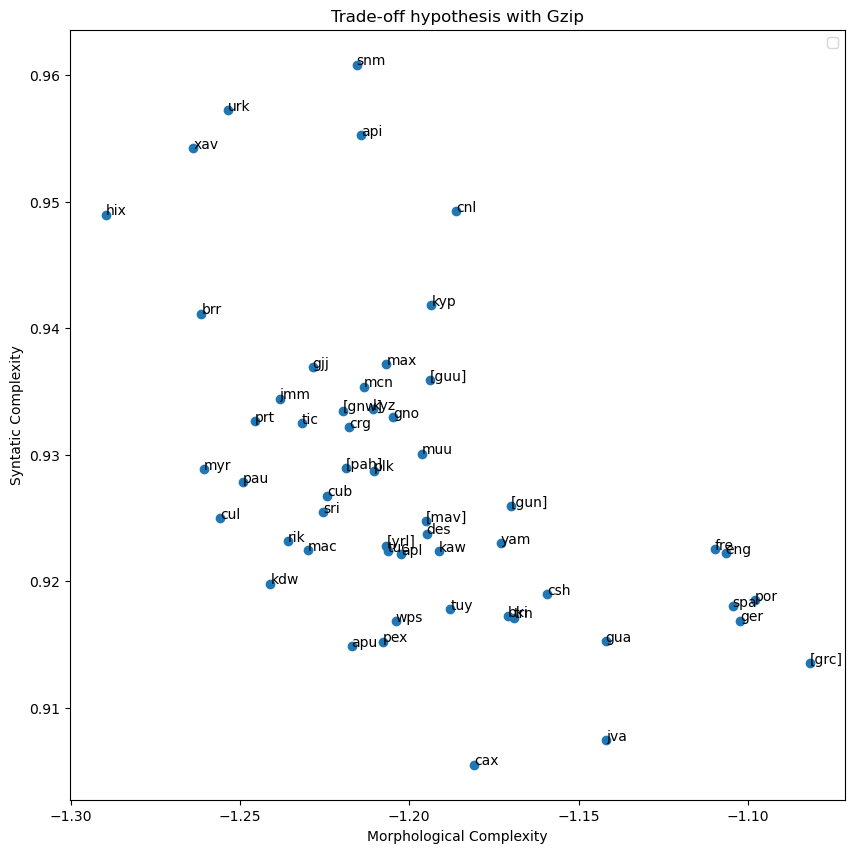

In [35]:
ploth3(df, 'gzip', languages - outliers1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


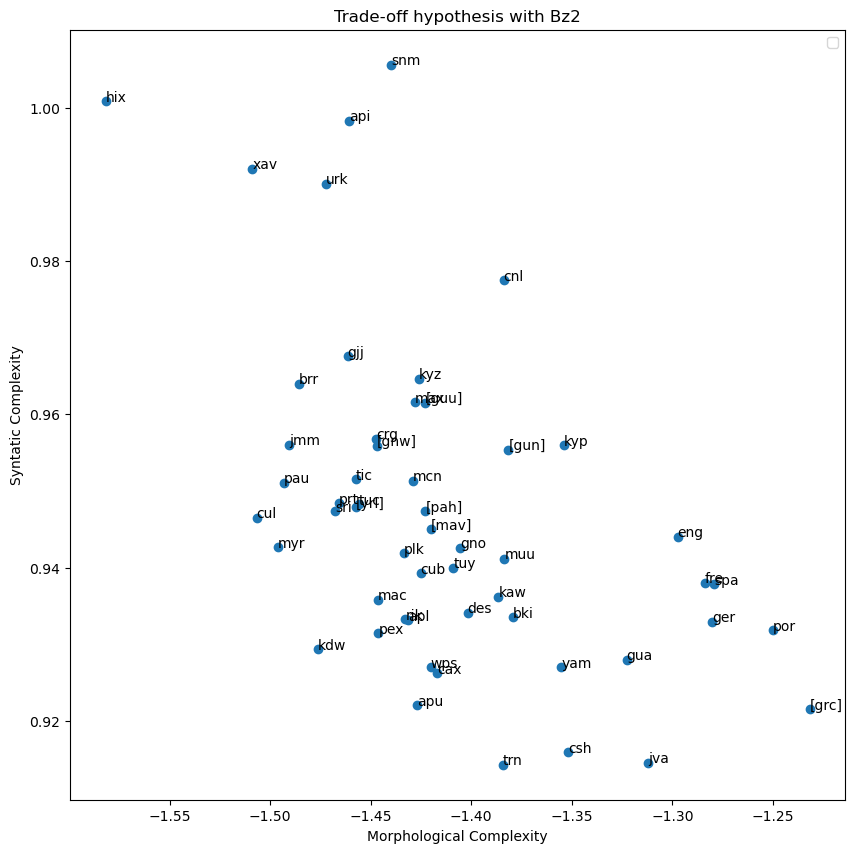

In [36]:
ploth3(df, 'bz2', languages - outliers1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


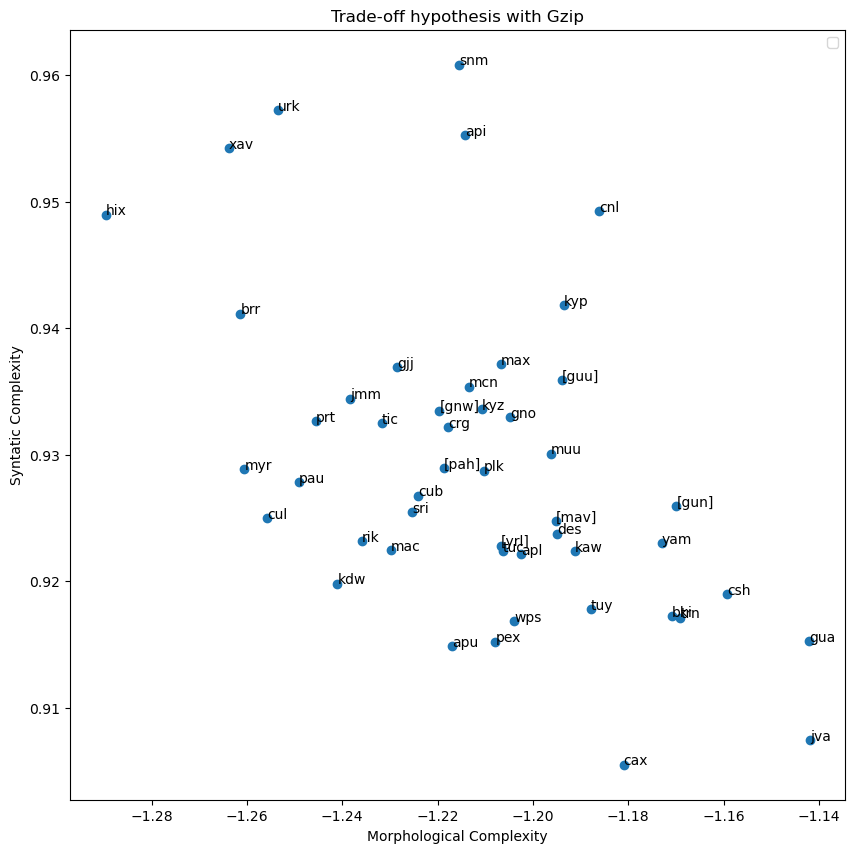

In [37]:
ploth3(df, 'gzip', languages - outliers1 - outliers2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


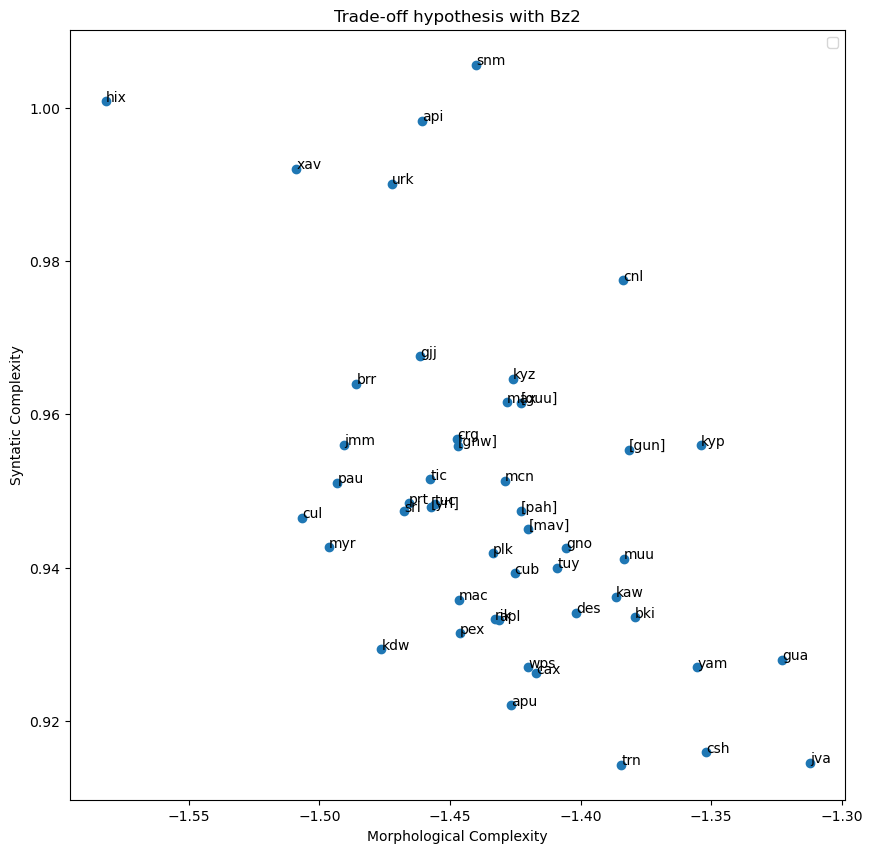

In [38]:
ploth3(df, 'bz2', languages - outliers1 - outliers2)

In [39]:
def morphological_syntactic_correlation(df):
    x = df['del-chars'].to_numpy()
    y = df['del-words'].to_numpy()
    return sp.stats.pearsonr(x, y)

In [40]:
morphological_syntactic_correlation(h3(df, 'gzip')), morphological_syntactic_correlation(h3(df, 'bz2'))

(PearsonRResult(statistic=-0.4541898766655309, pvalue=0.0004378928698941601),
 PearsonRResult(statistic=-0.47129901429564836, pvalue=0.0002460933014136841))

In [41]:
o1 = df[df.wals.isin(languages - outliers1)]
morphological_syntactic_correlation(h3(o1, 'gzip')), morphological_syntactic_correlation(h3(o1, 'bz2'))

(PearsonRResult(statistic=-0.5284089923801623, pvalue=4.0088982188476506e-05),
 PearsonRResult(statistic=-0.5210910396842782, pvalue=5.3467692179908166e-05))

In [42]:
o2 = df[df.wals.isin(languages - outliers1 - outliers2)]
morphological_syntactic_correlation(h3(o1, 'gzip')), morphological_syntactic_correlation(h3(o1, 'bz2'))

(PearsonRResult(statistic=-0.5284089923801623, pvalue=4.0088982188476506e-05),
 PearsonRResult(statistic=-0.5210910396842782, pvalue=5.3467692179908166e-05))

# O1 Morphological Complexity, tokens and types
a) There exists a **positive** correlation between morphological complexity and **the number of types** in a sample.

b) There exists a **negative** correlation between morphological complexity and **the number of tokens** in a sample.

In [43]:
d = compute_numtypes_numtokens(bibles)

tdf = pd.DataFrame(d).sort_values('language')

repwords_gzip = fetch_algorithm(df, 'rep-words', 'gzip').value.to_numpy()
repwords_bz2 = fetch_algorithm(df, 'rep-words', 'bz2').value.to_numpy()
s = "%s) corr=%0.4f, p-value=%g"

print("Gzip results:")
a = sp.stats.pearsonr(tdf.types.to_numpy(), repwords_gzip)#.value.to_numpy())
b = sp.stats.pearsonr(tdf.tokens.to_numpy(), repwords_gzip)#.value.to_numpy())
print(s % ("a", a.statistic, a.pvalue))
print(s % ("b", b.statistic, b.pvalue))

print("\nBz2 results:")
a = sp.stats.pearsonr(tdf.types.to_numpy(), repwords_bz2)#.value.to_numpy())
b = sp.stats.pearsonr(tdf.tokens.to_numpy(), repwords_bz2)#.value.to_numpy())
print(s % ("a", a.statistic, a.pvalue))
print(s % ("b", b.statistic, b.pvalue))

Gzip results:
a) corr=0.7819, p-value=1.1336e-12
b) corr=-0.8209, p-value=9.53573e-15

Bz2 results:
a) corr=0.7614, p-value=9.63016e-12
b) corr=-0.8349, p-value=1.27415e-15


# O2 All languages are equal in a pragmatic sense
The varinace of the pragmatic complexity should be the smallest.

In [44]:
df2 = fetch_all_metric_algorithms(df)

do_nothing = df2.metric == 'do-nothing'
none = df2.algorithm == 'none'
df3 = df2.loc[~do_nothing & ~none].sort_values("var").reset_index().drop(columns='index')
m = df3.groupby(by=['algorithm', 'metric'])['mean'].transform('mean')
v = df3.groupby(by=['algorithm', 'metric'])['mean'].transform('std')**2
df4 = df3.copy()
df4['mean'] = m
df4['var'] = v
df5 = df4.drop_duplicates(["metric", "algorithm"]).drop(columns=['language', 'wals'])

df5.sort_values('var')

,metric,algorithm,value,mean,var
282,del-verses,gzip,0.904302,0.904296,0.000002
307,del-verses,bz2,0.888515,0.904005,0.000052
34,del-words,gzip,0.933770,0.929086,0.000171
23,del-words,bz2,0.944746,0.948559,0.000500
28,del-chars,gzip,-1.206897,-1.198566,0.002090
49,del-chars,bz2,-1.506403,-1.413138,0.004775
3,rep-words,bz2,0.926799,0.907339,0.013974
0,rep-words,gzip,0.667520,0.875757,0.018610


# O3 Morphological complexity metric agrees with Nichol's

In [45]:
nichols_complexity = pd.read_csv('../dataset/complexity_ldst.csv', index_col=None)

In [46]:
def O3(df, nc, languages, metric_str, algorithm_str):
    #df3 = df2[df2.language.isin(languages)]
    langs = df.language.isin(languages)
    metric = df.metric == metric_str
    algorithm = df.algorithm == algorithm_str
    a = df[langs & metric & algorithm].sort_values('language')['mean'].to_numpy()
    b = nc[nc.language.isin(languages)].sort_values('language')['value'].to_numpy()
    #print(len(a), len(b))
    r = sp.stats.pearsonr(a, b)
    print('%r %s %s -> pearsonr=%0.4f p-value=%g' % (languages, metric_str, algorithm_str, r.statistic, r.pvalue))
    #return sp.stats.pearsonr(a, b)

In [47]:
df2 = fetch_all_metric_algorithms(df)
languages = set(nichols_complexity.language) & set(df.language)

#O3(df2, nichols_complexity, languages, 'rep-words', 'gzip')

O3(df2, nichols_complexity, languages, 'del-chars', 'gzip')

#O3(df2, nichols_complexity, languages, 'rep-words', 'bz2')

O3(df2, nichols_complexity, languages, 'del-chars', 'bz2')

languages = languages - set(["FRENCH"]); print('removing French')

#O3(df2, nichols_complexity, languages, 'rep-words', 'gzip')

O3(df2, nichols_complexity, languages, 'del-chars', 'gzip')

#O3(df2, nichols_complexity, languages, 'rep-words', 'bz2')

O3(df2, nichols_complexity, languages, 'del-chars', 'bz2')

{'KASHINAWA', 'ASHENINKA', 'ENGLISH', 'HIXKARYÁNA', 'CANELA', 'FRENCH'} del-chars gzip -> pearsonr=-0.0374 p-value=0.943975
{'KASHINAWA', 'ASHENINKA', 'ENGLISH', 'HIXKARYÁNA', 'CANELA', 'FRENCH'} del-chars bz2 -> pearsonr=0.0352 p-value=0.94723
removing French
{'KASHINAWA', 'HIXKARYÁNA', 'ASHENINKA', 'ENGLISH', 'CANELA'} del-chars gzip -> pearsonr=-0.5689 p-value=0.316904
{'KASHINAWA', 'HIXKARYÁNA', 'ASHENINKA', 'ENGLISH', 'CANELA'} del-chars bz2 -> pearsonr=-0.4625 p-value=0.432853


In [64]:
m = df2.metric == 'del-chars'
df2[m & (df2.algorithm == 'gzip') & df2.language.isin(nichols_complexity.language)].sort_values('mean')

,language,wals,metric,algorithm,value,mean,var
270,HIXKARYÁNA,hix,del-chars,gzip,-1.287126,-1.289684,1.470752e-06
118,CANELA,cnl,del-chars,gzip,-1.184510,-1.186128,1.049537e-06
60,ASHENINKA,cax,del-chars,gzip,-1.178778,-1.180946,8.825035e-07
381,KASHINAWA,csh,del-chars,gzip,-1.161366,-1.159207,1.377237e-06
174,FRENCH,fre,del-chars,gzip,-1.109295,-1.109799,7.824456e-07
154,ENGLISH,eng,del-chars,gzip,-1.108117,-1.106589,1.326628e-06


In [48]:
dff = df.copy()
dff.loc[dff.metric == 'rep-words', 'value'] = 1/dff[dff.metric == 'rep-words']['value']
df3 = fetch_all_metric_algorithms(dff)

languages = set(nichols_complexity.language) & set(dff.language)

O3(df3, nichols_complexity, languages, 'rep-words', 'gzip')

#O3(df3, nichols_complexity, languages, 'del-chars', 'gzip')

O3(df3, nichols_complexity, languages, 'rep-words', 'bz2')

#O3(df3, nichols_complexity, languages, 'del-chars', 'bz2')

languages = languages - set(["FRENCH"]); print('removing French')

O3(df3, nichols_complexity, languages, 'rep-words', 'gzip')

#O3(df3, nichols_complexity, languages, 'del-chars', 'gzip')

O3(df3, nichols_complexity, languages, 'rep-words', 'bz2')

#O3(df3, nichols_complexity, languages, 'del-chars', 'bz2')

{'KASHINAWA', 'ASHENINKA', 'ENGLISH', 'HIXKARYÁNA', 'CANELA', 'FRENCH'} rep-words gzip -> pearsonr=0.1216 p-value=0.818481
{'KASHINAWA', 'ASHENINKA', 'ENGLISH', 'HIXKARYÁNA', 'CANELA', 'FRENCH'} rep-words bz2 -> pearsonr=0.1004 p-value=0.849956
removing French
{'KASHINAWA', 'HIXKARYÁNA', 'ASHENINKA', 'ENGLISH', 'CANELA'} rep-words gzip -> pearsonr=0.2247 p-value=0.716299
{'KASHINAWA', 'HIXKARYÁNA', 'ASHENINKA', 'ENGLISH', 'CANELA'} rep-words bz2 -> pearsonr=0.2672 p-value=0.663893


# Compression algorithm approximates Kolgomorov Complexity
The results are equivalent wheter using **Gzip** or **Bz2**.

# Correlation between morphological complexities

In [49]:
df2 = fetch_all_metric_algorithms(df)

In [50]:
def corr_morph_complex(df):
    repwords = df.metric == 'rep-words'
    delchars = df.metric == 'del-chars'
    gzip = df.algorithm == 'gzip'

    a = df[repwords & gzip]['mean'].to_numpy()
    b = df[delchars & gzip]['mean'].to_numpy()
    plt.scatter(a, b)
    r = sp.stats.pearsonr(a, b)
    return "corr=%0.4f p-value=%g" % (r.statistic, r.pvalue)
    #return df2.drop(columns=['language', 'wals', 'value', 'var']).drop_duplicates(['metric', 'algorithm'])

'corr=-0.3281 p-value=0.0135551'

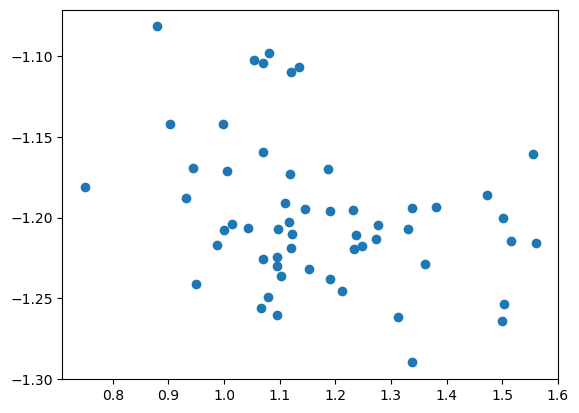

In [51]:
corr_morph_complex(df3)

In [52]:
df3[(df3.metric == 'rep-words') & (df3.algorithm == 'gzip')].sort_values('mean')

,language,wals,metric,algorithm,value,mean,var
65,ASHENINKA,cax,rep-words,gzip,0.748751,0.750028,4.508769e-07
4,ANCIENT_GREEK,[grc],rep-words,gzip,0.879161,0.879531,8.911154e-07
367,KARAJÁ,jva,rep-words,gzip,0.903891,0.903527,1.594413e-07
756,TUYÚCA,tuy,rep-words,gzip,0.930595,0.931550,8.060261e-07
706,TERÊNA,trn,rep-words,gzip,0.944026,0.943738,1.972377e-07
329,KADIWÉU,kdw,rep-words,gzip,0.950411,0.950214,3.558595e-07
46,APURINÃ,apu,rep-words,gzip,0.988701,0.988267,3.506000e-07
249,GUARANI_PARAGUAY,gua,rep-words,gzip,0.996942,0.998073,8.403715e-07
568,PARECÍS,pex,rep-words,gzip,1.000176,0.999591,5.527323e-07
83,BAKAIRI,bki,rep-words,gzip,1.004196,1.004819,3.726932e-07


In [53]:
df3[(df3.metric == 'del-chars') & (df3.algorithm == 'gzip')].sort_values('mean')

,language,wals,metric,algorithm,value,mean,var
270,HIXKARYÁNA,hix,del-chars,gzip,-1.287126,-1.289684,1.470752e-06
797,XAVANTE,xav,del-chars,gzip,-1.263321,-1.263793,7.732650e-07
99,BORÔRO,brr,del-chars,gzip,-1.262072,-1.261372,1.580593e-06
473,MATSÉS,myr,del-chars,gzip,-1.261073,-1.260545,9.948268e-07
133,CULINA,cul,del-chars,gzip,-1.255178,-1.255837,1.506565e-06
307,KAAPOR,urk,del-chars,gzip,-1.253569,-1.253572,1.710217e-06
578,PAUMARÍ,pau,del-chars,gzip,-1.247789,-1.249064,9.315198e-07
585,PIRATAPÚYA,prt,del-chars,gzip,-1.244051,-1.245540,1.216230e-06
322,KADIWÉU,kdw,del-chars,gzip,-1.239902,-1.241028,9.549063e-07
290,JAMAMADI,jmm,del-chars,gzip,-1.236254,-1.238289,1.408029e-06


'corr=0.3447 p-value=0.00928078'

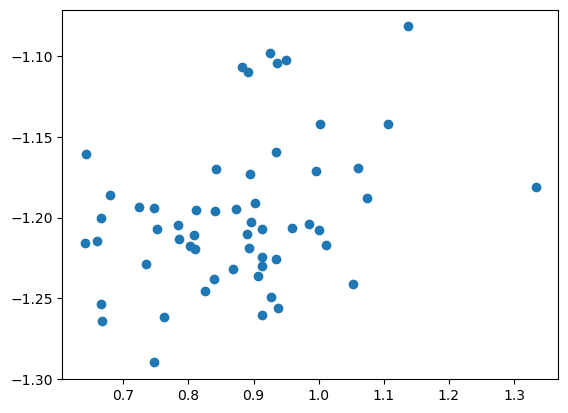

In [54]:
corr_morph_complex(df2)

In [55]:
len(set(df2.language))

56